A couple of break throughs:

1) Your outbreak starts with an index EXPOSED NOT an index infected

2) The indicies of the x and y coordinates, and status changes at the beginning of the outbreak function. So you need to change the index of the index exposed when you calculate distance. Even though it is the first index outside of the function, it will be something else once the indicies have been sorted within the function

3) You can't have a status = -1 (i.e. culling) in the function, so this Outbreak Function has been changed so that the status indicator keeps increasing. The status of a farm is still considered infected if Status > 5, but we stop the outbreak at the "end" day so the status values don't forever increase or max iterate at 1000 iterations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(53080)
mean1 = [4, 4]
cov1 = [[2.5, 0], [0, 2.5]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 250).T
mean2 = [11, 10]
cov2 = [[3.5, 0], [0, 2.5]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 250).T
mean3 = [5, 15]
cov3 = [[3.5, 0], [0, 2.5]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, 250).T
mean4 = [15, 4]
cov4 = [[3.5, 0], [0, 2.5]]
x4, y4 = np.random.multivariate_normal(mean4, cov4, 250).T

x = np.r_[x1,x2,x3,x4]
y = np.r_[y1,y2,y3,y4]

ind1 = []
ind2 = []

for i in range(len(x)):
    ind1.append(np.logical_or(x[i]<0, x[i]>20))
    ind2.append(np.logical_or(y[i]<0, y[i]>20))
print(np.sum(ind1),np.sum(ind2))

for i in range(len(x)):
    if np.logical_or(x[i]<0, x[i]>20):
        x[i] = np.random.rand(1)*20
    if np.logical_or(y[i]<0, y[i]>20):
        y[i] = np.random.rand(1)*20

from random import randint
np.random.seed(1300)
Cows = np.r_[np.array([randint(500,1000) for p in range(250)]),np.array([randint(200,500) for p in range(750)])]
np.random.seed(1400)
Sheep = np.r_[np.array([randint(500,1000) for p in range(250)]),np.array([randint(200,500) for p in range(750)])]

1 0


In [6]:
N = 1000
Size = 20
#This is the index exposed farm in the outbreak function
Status = np.array([0]*N)    #Initial Status of each farm
for i in range(1):
    Status[i] = 1
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
    #Returns a number from 1 to griddim^2
    return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

#Set up the grid
grid = WhichGrid(x,y,Size,Size,10.0,10.0)
tmp = sorted(grid) #Sort grid values
i = np.argsort(grid) #get indexed values after sort
Status = Status[i]
x = x[i]
y = y[i]
np.where(Status==1)


(array([291]),)

In [2]:
def Outbreaks(Size,N,Y0,farms,end,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    #Generate dataset (assume there are the same amount of animals at each farm)
    #np.random.seed(10)
    #x = Size*np.random.rand(N)
    #np.random.seed(11)
    #y = Size*np.random.rand(N)
    #Cows = np.array([250]*N)  #Number of cows at each farm
    #Sheep = np.array([250]*N)  #Number of cows at each farm
    Status = np.array([0]*N)    #Initial Status of each farm
    for i in range(Y0):
        Status[i] = 1

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(Status>5)[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        #for i in range(len(m)):
        #    Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<end, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if np.logical_or((E[-4]+I[-4]==0),len(I) == N):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full

    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (no_this[:,2]>5).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[291][0],coords[291][1]))
    dist = []
    for i in range(0,N):
        b = np.array((coords[i][0],coords[i][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep]
    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep
    return(to_return)

In [3]:
import numpy as np
Size = 20
N = 1000   
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)
Num_outbreaks = 500
for i in range(Num_outbreaks):
    new_Outbreak = np.r_[Outbreak,Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)]
    Outbreak = new_Outbreak 
run = np.ravel(list([i]*N for i in range(1,Num_outbreaks+2)))
data = np.c_[run,Outbreak]

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:92: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:101: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [24]:
#For ease turn data array into data frame
import pandas as pd
df = pd.DataFrame(data)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep']
long_one_big_clust = df

In [25]:
long_one_big_clust.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/long_one_big_clust.pkl') 

In [5]:
#Group by farmID then add across farmIDs 
farm_Status = df[['Status']].groupby(df.farmID)
sum_Status = farm_Status.agg(np.sum)
#Get rid of hierarchical header for data merge
sum_Status.columns = sum_Status.columns.get_level_values(0)
sum_Status2 = pd.DataFrame(sum_Status).reset_index()
#Add rest of data covariates
subset = df[:1000][['farmID','DistToIndex','NumCows','NumSheep']]
one_big_clust = pd.concat([sum_Status2, subset], axis=1, join_axes=[subset.index])
one_big_clust[290:]

,farmID,Status,farmID,DistToIndex,NumCows,NumSheep
290,291,501,291,2.964202,360,305
291,292,501,292,0.000000,352,463
292,293,501,293,0.262659,391,302
293,294,501,294,1.335697,325,360
294,295,501,295,0.312422,397,380
295,296,501,296,1.247280,439,395
296,297,501,297,1.192060,269,444
297,298,501,298,0.614850,292,220
298,299,501,299,1.449655,314,425
299,300,501,300,0.870234,434,494


In [26]:
#Save (or pickle) the dataset for future use
one_big_clust.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/one_big_clust.pkl') 

In [3]:
#Read the pickled dataset back in - prevents having to run all above code again
import pandas as pd
one_big_clust = pd.read_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/one_big_clust.pkl')

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


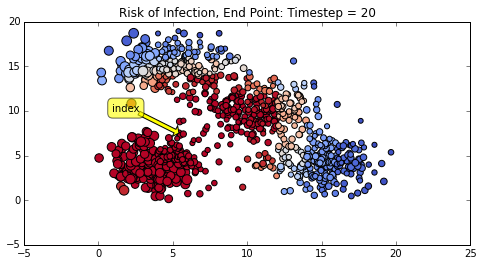

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,c=one_big_clust['Status'],cmap=plt.cm.coolwarm,s=(Cows+Sheep)/20)
plt.title('Risk of Infection, End Point: Timestep = 20')
plt.annotate('index', xy = (x[291], y[291]), xytext = (-40, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha = 0.6),
        arrowprops=dict(facecolor='yellow', shrink=0.00005))


plt.show()

In [8]:
dist_diff = one_big_clust['DistToIndex'] - one_big_clust['DistToIndex'].mean()
cows_diff = one_big_clust['NumCows'] - one_big_clust['NumCows'].mean()
sheep_diff = one_big_clust['NumSheep'] - one_big_clust['NumSheep'].mean()
status = one_big_clust['Status']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0.5) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = -0.05)
    
    b = Normal('b', mu=0., tau=0.001, value = [0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, b=b: invlogit(intercept + first_coef*dist_diff + b[0]*cows_diff 
                                               + b[1]*sheep_diff))
    
    y = Binomial('y', n=501, p=prob, value=status, observed=True)
    
    return locals()

In [9]:
chains = 2
iterations = 15000
burn = 9000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 15000 of 15000 complete in 35.3 sec

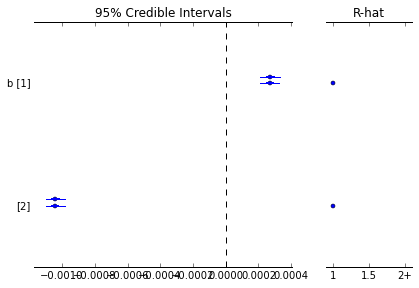

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.b)

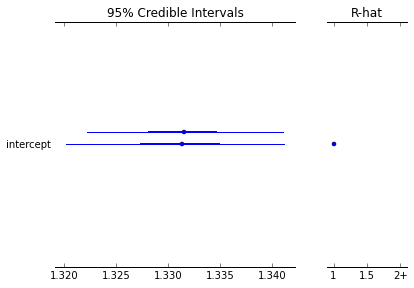

In [11]:
Matplot.summary_plot(M_pooled.intercept)

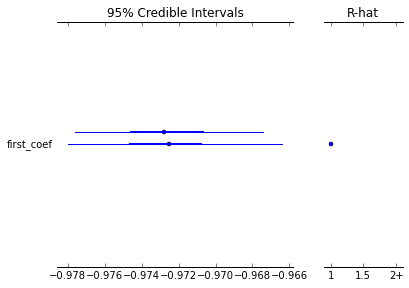

In [12]:
Matplot.summary_plot(M_pooled.first_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


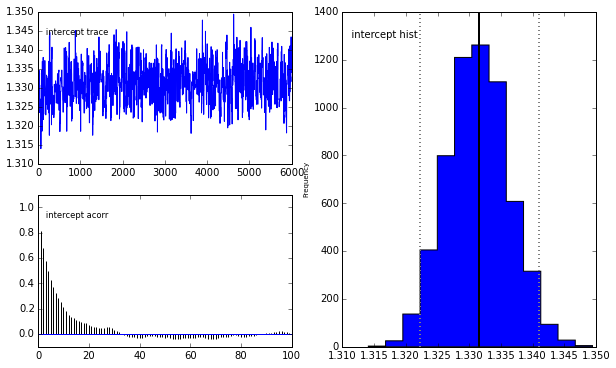

In [13]:
Matplot.plot(M_pooled.intercept)

Plotting b_0
Plotting b_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


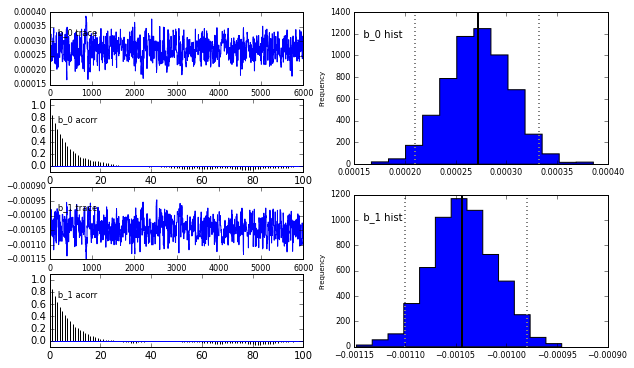

In [14]:
Matplot.plot(M_pooled.b, common_scale=False)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


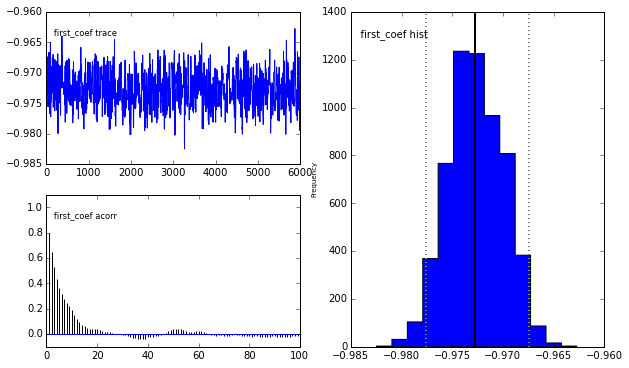

In [15]:
Matplot.plot(M_pooled.first_coef, common_scale=False)

In [16]:
from pymc import gelman_rubin
gelman_rubin(M_pooled)

{'b': [1.0002734020815967, 0.99983680748846737],
 'first_coef': 1.0004058792190416,
 'intercept': 1.0010568441257064,
 'prob': [1.0001658326753593,
  1.0013395606554485,
  1.001839802377499,
  1.0011734788880611,
  1.0018496717566108,
  1.0016105012822543,
  1.0016747310331033,
  1.0017480481611667,
  1.0015932209808367,
  1.0017398824734727,
  1.0017394644298689,
  1.0006133342505357,
  1.002114471439129,
  1.0017697422496568,
  1.0019544932216182,
  1.0016472176873652,
  1.0015362821247398,
  1.0002120400491898,
  1.0015908945243128,
  1.0011886821866134,
  1.0019071095087877,
  1.0017905974856598,
  1.0005835709848736,
  1.0007066707939074,
  0.99994935506591609,
  1.0010291339576307,
  1.0007517208335155,
  1.0009012183375041,
  1.0003852668316073,
  1.0006073682599328,
  1.0008703311807712,
  1.000782145397052,
  1.0000407017278963,
  0.99985760873251717,
  1.0011925975516756,
  1.0015894075926897,
  1.0012840996722312,
  1.001610279627217,
  1.0016942249233931,
  1.00096698228390

In [17]:
M_pooled.b.summary()


b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.0              0.0              0.0                    [ 0.  0.]
	-0.001           0.0              0.0              [-0.001 -0.001]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             0.0            0.0           0.0
	-0.001           -0.001          -0.001         -0.001        -0.001
	


In [18]:
M_pooled.intercept.summary()


intercept:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.331            0.005            0.0              [ 1.321  1.341]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.321            1.328           1.331          1.335         1.341
	


In [19]:
M_pooled.first_coef.summary()


first_coef:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.973           0.003            0.0              [-0.978 -0.967]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.978           -0.975          -0.973         -0.971        -0.967
	


In [20]:
import numpy as np
#Intercept: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('intercept')[:].mean()),np.exp(np.percentile(M_pooled.trace('intercept')[:],2.5)),np.exp(np.percentile(M_pooled.trace('intercept')[:],97.5)))

(3.7863244336063473, 3.7511521050888286, 3.8224199062540922)

In [21]:
#distance: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('first_coef')[:].mean()),np.exp(np.percentile(M_pooled.trace('first_coef')[:],2.5)),np.exp(np.percentile(M_pooled.trace('first_coef')[:],97.5)))

(0.37807666522783889, 0.37613528102011629, 0.37999413388974501)

In [22]:
# #cows: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('b')[:,0].mean()),np.exp(np.percentile(M_pooled.trace('b')[:,0],2.5)),np.exp(np.percentile(M_pooled.trace('b')[:,0],97.5)))

(1.0002727355416592, 1.0002109400077075, 1.0003337800233756)

In [23]:
# #sheep: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('b')[:,1].mean()),np.exp(np.percentile(M_pooled.trace('b')[:,1],2.5)),np.exp(np.percentile(M_pooled.trace('b')[:,1],97.5)))

(0.99895785053171582, 0.99889756105445959, 0.99901991319083516)